Para a determinação da autocorrelação espacial é necessário calcular a matrix de ponderação espacial $W$, cujo elemento $w_{ij}$ representa o grau de influência do elemento $j$ ao elemento $i$.

Calcular tal matriz diretamente para os os 58.000 imóveis torna-se inapropriado pelas limitações de memória. Adicionalmente, em função da esparsidade decorrente da premissa de Tobler de que tudo está relacionado, mas o que o que está mais próximo tem um peso maior, podemos estruturar o armazenamento de tal matriz de forma diferente.

 http://nbviewer.ipython.org/github/choct155/TEL/blob/master/ipynb/pysal_autocorrelation.ipynb
 
 ### ArcGIS
 ArcGIS não é freeware. ArcgGIS depende de dlls para se conectar ao PostGIS. O Plug in "OGR" não lista views materializadas.



In [1]:
%pylab inline

import zap_util as z
import pysal
import geopandas as gp

from datetime import datetime
z.set_style()
#http://gis.stackexchange.com/questions/106924/gearys-index-of-spatial-autocorrelation

Populating the interactive namespace from numpy and matplotlib


# Testar criar W por shapefile programaticamente.

Infelizmente Pysal não calcula threshold mínimo de distância para pontos, somente para shapefile.


In [13]:
# Trocar nome da coluna 'geom' por 'geometry' para compatibilidade com shape file.
df = z.get_imoveis_dataframe(False)
df = df[df.bairro_g == 'Tijuca']
for c in [i for i in df.columns.tolist() if i.find('se_') > -1]:
    del df[c]


In [38]:
ids = ','.join(['\'{}\''.format(i) for i in df.index.tolist()])
sql = 'select id, geom as geometry from vw_imovel ' + \
    'where id in ({})'.format(ids)
dg = gp.GeoDataFrame.from_postgis(sql,z.d.conecta_db(), geom_col='geometry')


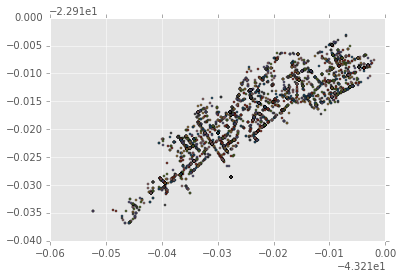

In [41]:
dg.plot();


In [42]:
m = df[['preco','lng','lat']].values
y = df.preco.values
X = df[['lng','lat']].values
w = pysal.kernelW(X, k=5)
w.transform = 'r'
#w = pysal.adaptive_kernelW(X, bandwidths=1)

In [45]:
# Erro: https://groups.google.com/forum/#!topic/openspace-list/XiXf7I1FpxY

pysal.knnW_from_array(X)

AttributeError: 'module' object has no attribute '_support'

In [43]:
gal = pysal.open('W_Tijuca.gal','w')
gal.write(w)
gal.close()

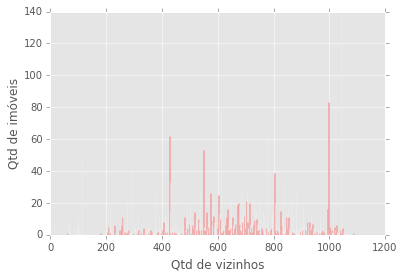

In [44]:
# Vejamos como ficou a distribuição de vizinhos.
#nv = [len(v) for v in w.neighbors.values()]
#hist(nv, 30);
h = array(w.histogram)
bar(h[:,0],h[:,1],color='r');
ylabel(u'Qtd de imóveis')
xlabel(u'Qtd de vizinhos');

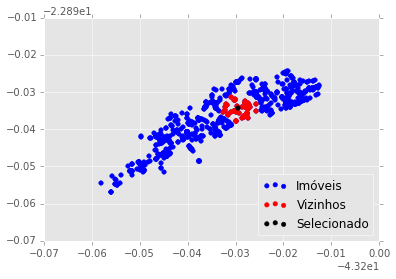

In [7]:
# Visualização do imóvel e seus vizinhos.
idx = 90
X1 = X[[w[idx].keys()]]
scatter(X[:,0],X[:,1], color='b', label=u'Imóveis')
scatter(X1[:,0],X1[:,1], color='r', label='Vizinhos')
scatter(X[idx,0], X[idx,1], color='black', label='Selecionado')
legend(loc='lower right');

In [8]:
# Moran's I
mi = pysal.Moran(y,w)
mi.I


0.19349944617610632

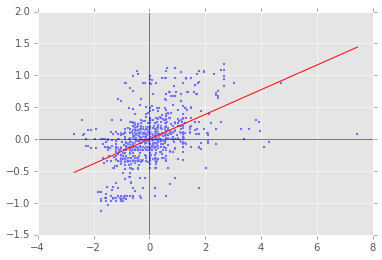

In [9]:
# Moran scatter plot



from scipy.stats import zscore

yz = zscore(y)

miz = pysal.Moran(yz,w)
ylz = pysal.lag_spatial(w, yz)


scatter(yz,ylz,marker='.')
dx = min(yz),max(yz)
dy = polyval([miz.I,0], dx)
plot(dx,dy,'r-')
axhline(0,color='black', alpha=0.5)
axvline(0,color='black', alpha=0.5)



In [10]:
miz.I,mi.I

(0.19349944617610659, 0.19349944617610632)

In [11]:
df

,id,preco,lng,lat,geometry
0,5900374,565.000,-43.234013,-22.924336,POINT (-43.2340127 -22.9243357)
1,6171804,870.000,-43.215412,-22.919886,POINT (-43.2154121398 -22.9198856353)
2,5567297,1000.000,-43.243465,-22.933792,POINT (-43.2434654235 -22.9337921142)
3,6108720,490.000,-43.249522,-22.939579,POINT (-43.2495225 -22.9395787)
4,5834259,425.000,-43.237730,-22.927487,POINT (-43.2377302 -22.9274873)
5,6044839,487.000,-43.249522,-22.939579,POINT (-43.2495225 -22.9395787)
6,6110170,520.000,-43.234131,-22.923000,POINT (-43.2341308593 -22.9230003356)
7,6370552,750.001,-43.237339,-22.927240,POINT (-43.2373390197 -22.9272403717)
8,6208090,695.000,-43.245512,-22.933597,POINT (-43.2455118 -22.9335968)
9,6208312,550.000,-43.221276,-22.920021,POINT (-43.2212761 -22.9200206)
